In [1]:
from teleconnections.plots import hovmoller_plot
from aqua import Reader
import teleconnections.tools as tc_tools
import aqua.util as aq_tools

In [31]:
configdir = aq_tools.get_config_dir()
machine = aq_tools.get_machine(configdir=configdir)

diagnostic = 'teleconnections'
telecname = 'MJO2'

model = 'IFS'
exp = 'tco1279-orca025-cycle3'
source = '2D_1h_0.25deg'

namelist = tc_tools.load_namelist()

field = namelist[telecname]['field']

In [32]:
print('Box:')
print('latN: {}'.format(namelist[telecname]['latN']))
print('latS: {}'.format(namelist[telecname]['latS']))
print('lonW: {}'.format(namelist[telecname]['lonW']))
print('lonE: {}'.format(namelist[telecname]['lonE']))

Box:
latN: 15
latS: -15
lonW: 0
lonE: 360


In [4]:
reader = Reader(model=model,exp=exp,source=source, regrid='r025', freq='daily', loglevel='INFO')

In [5]:
data = reader.retrieve(var=field)

2023-07-14 15:40:56 :: Reader :: INFO     -> Retrieving variables: ['mtntrf']
2023-07-14 15:41:12 :: Reader :: INFO     -> mtntrf: J m**-2 --> W m**-2
2023-07-14 15:41:12 :: Reader :: INFO     -> mtntrf: corrected dividing by accumulation time 3600 s
2023-07-14 15:41:12 :: Reader :: INFO     -> Fixing ttr to mtntrf. Unit fix: factor=0.000278, offset=0.000000
2023-07-14 15:41:13 :: Reader :: INFO     -> Data model: /home/b/b382289/AQUA/config/data_models/ifs2cds.json


In [33]:
sel = {'time': slice('2021-01-01','2021-06-30')}

data_sel = data.sel(**sel)

In [34]:
data_sel = reader.timmean(data_sel)
data_sel = reader.regrid(data_sel)

2023-07-14 16:09:05 :: Reader :: INFO     -> Resamplig to 1D frequency...


In [8]:
from teleconnections.plots import hovmoller_plot

In [35]:
# from here is the data analysis that should become a function

latN = namelist[telecname]['latN']
latS = namelist[telecname]['latS']
lonW = namelist[telecname]['lonW']
lonE = namelist[telecname]['lonE']

# selecting the MJO region
data_sel = tc_tools.area_selection(data_sel, lat= [latS, latN], lon=[lonW, lonE])

# Evaluating the anomalies
data_mean = data_sel.mean(dim='time', keep_attrs=True)
data_anom = data_sel - data_mean

# smoothing the data with a 5-day running mean
data_smooth = data_anom.rolling(time=5, center=True).mean()

2023-07-14 16:23:40 :: Hovmoller :: DEBUG    -> Plotting Hovmoller diagram
2023-07-14 16:23:40 :: Hovmoller :: INFO     -> Averaging over dimension: lat
2023-07-14 16:23:40 :: Hovmoller :: DEBUG    -> Cbar limits set by user
2023-07-14 16:23:40 :: Hovmoller :: DEBUG    -> vmin: -80, vmax: 80
2023-07-14 16:23:40 :: Hovmoller :: DEBUG    -> Centering colorbar around zero
2023-07-14 16:23:40 :: Hovmoller :: WARNING  -> Cbar limits set by user, ignoring center
2023-07-14 16:23:40 :: Hovmoller :: DEBUG    -> vmin: -80, vmax: 80


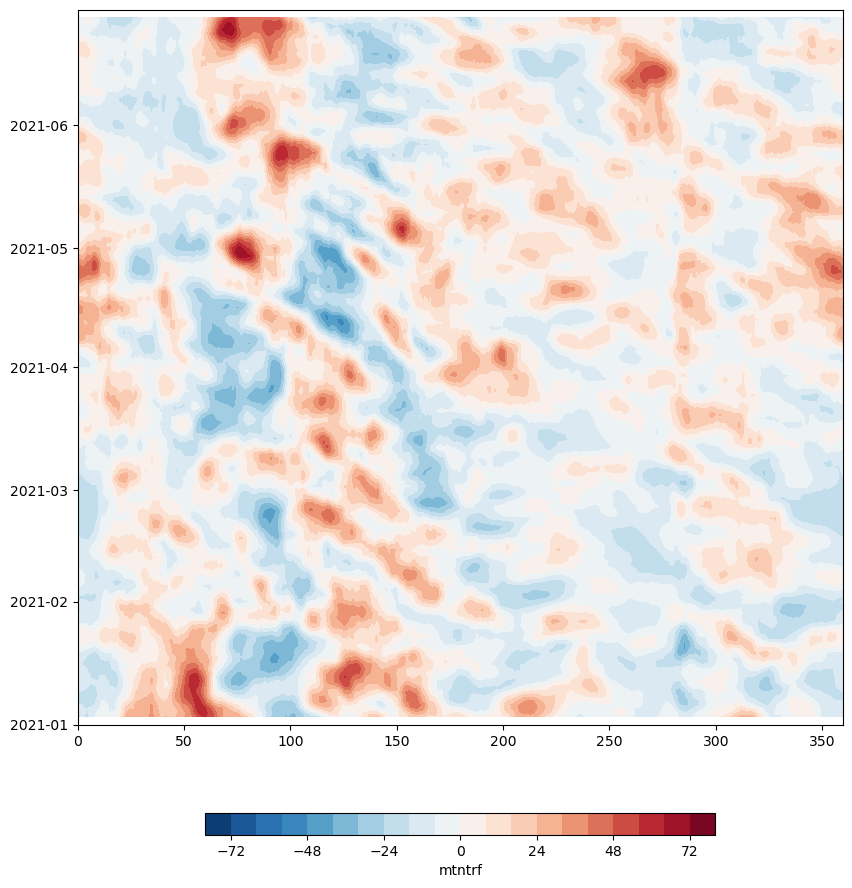

In [49]:
hovmoller_plot2(data_smooth[field], dim='lat', invert_axis=True, cbar_label=field, nlevels=21, loglevel='DEBUG', center=True,vmin=-80,vmax=80)

In [48]:
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from aqua.logger import log_configure


def hovmoller_plot2(data: xr.DataArray, invert_axis=False, center=False,
                   contour=True, save=False, **kwargs):
    """"
    Args:
        data (DataArray):       DataArray to be plot
        invert_axis (bool,opt): enable or disable axis inversion,
                                default is False
        center (bool,opt):      center the cbar around zero,
                                default is False
        contour (bool,opt):     True for contour plot, False for pcolormesh,
                                default is True
        save (bool,opt):        save the figure, default is False
        **kwargs:               additional arguments

    Kwargs:
        loglevel (str,opt):     log level for the logger,
                                default is 'WARNING'
        dim (str,opt):          dimension to be averaged over,
                                default is 'lon'
        figsize (tuple,opt):    figure size, default is (11, 8.5)
        vmin (float,opt):       minimum value for the colorbar
        vmax (float,opt):       maximum value for the colorbar
        cmap (str,opt):         colormap, default is 'RdBu_r'
        nlevels (int,opt):      number of contour levels, default is 8
        cbar_label (str,opt):   colorbar label, default is None
        outputdir (str,opt):    output directory, default is '.'
        filename (str,opt):     output filename, default is 'hovmoller.png'
    """
    loglevel = kwargs.pop('loglevel', 'WARNING')
    logger = log_configure(log_level=loglevel, log_name='Hovmoller')

    logger.debug('Plotting Hovmoller diagram')

    # Check if data is a DataArray
    if not isinstance(data, xr.DataArray):
        logger.error('Data is not a DataArray')
        raise TypeError('Data is not a DataArray')

    # Evalueate the mean over the dimension to be averaged over
    dim = kwargs.get('dim', 'lon')
    logger.info('Averaging over dimension: {}'.format(dim))
    data_mean = data.mean(dim=dim, keep_attrs=True)

    # Create figure and axes
    figsize = kwargs.get('figsize', (8.5, 11))
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the data
    if invert_axis:
        x = data_mean.coords[data_mean.dims[-1]]
        y = data_mean.coords['time']
    else:
        x = data_mean.coords['time']
        y = data_mean.coords[data_mean.dims[-1]]

    vmin = kwargs.get('vmin', None)
    vmax = kwargs.get('vmax', None)

    if vmin is not None and vmax is not None:
        logger.debug('Cbar limits set by user')
        logger.debug('vmin: {}, vmax: {}'.format(vmin, vmax))
    if center:
        logger.debug('Centering colorbar around zero')
        if vmin is None or vmax is None:
            logger.warning('Exploring data to find absmax, may take a while')
            absmax = max(abs(data_mean.min().values),
                        abs(data_mean.max().values))
            vmin = -absmax
            vmax = absmax
        else:
            logger.warning('Cbar limits set by user, ignoring center')
        logger.debug('vmin: {}, vmax: {}'.format(vmin, vmax))
    else:
        logger.debug('Not centering colorbar around zero')
        if vmin is None:
            vmin = data_mean.min().values
        if vmax is None:
            vmax = data_mean.max().values

    cmap = kwargs.get('cmap', 'RdBu_r')
    if contour:
        nlevels = kwargs.get('nlevels', 8)
        
        levels = np.linspace(vmin, vmax, nlevels)
        if invert_axis:
            im = ax.contourf(x, y, data_mean, levels=levels, cmap=cmap,
                             vmin=vmin, vmax=vmax)
        else:
            im = ax.contourf(x, y, data_mean.T, levels=levels, cmap=cmap,
                             vmin=vmin, vmax=vmax)
    else:  # pcolormesh
        if invert_axis:
            im = ax.pcolormesh(x, y, data_mean, cmap=cmap,
                               vmin=vmin, vmax=vmax)
        else:
            im = ax.pcolormesh(x, y, data_mean.T, cmap=cmap,
                               vmin=vmin, vmax=vmax)

    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                        wspace=0.1, hspace=0.5)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.15, 0.6, 0.02])

    cbar_label = kwargs.get('cbar_label')
    if cbar_label is not None:
        fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                     label=cbar_label)
    else:
        try:
            fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                         label=data_mean.short_name)
        except AttributeError:
            fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    # Save the figure
    if save is True:
        outputdir = kwargs.get('outputdir', '.')

        # check the outputdir exists and create it if necessary
        if not os.path.exists(outputdir):
            logger.info('Creating output directory {}'.format(outputdir))
            os.makedirs(outputdir)
        try:
            filename = kwargs.get('filename')
        except ValueError:
            logger.info('No filename provided, using default')
            logger.debug('Trying to get model and experiment from kwargs')
            model = kwargs.get('model')
            exp = kwargs.get('exp')
            if model is None or exp is None:
                logger.error('No model or experiment provided')
                filename = 'hovmoller.pdf'
            else:
                filename = model + '_' + exp + '.pdf'

        logger.info('Saving figure to {}/{}'.format(outputdir, filename))
        fig.savefig('{}/{}'.format(outputdir, filename), format='pdf',
                    dpi=300, bbox_inches='tight')
